**PREDICTING SIERA**

Introduction

In recent years, Major League Baseball (MLB) front offices and evaluators have become increasingly disillusioned with traditional pitching metrics like Earned Run Average (ERA). While ERA has long been considered the gold standard for measuring a pitcher’s effectiveness, its limitations have become more apparent. ERA is highly susceptible to external factors such as defensive performance, ballpark variations, and luck. A pitcher's ERA can be significantly influenced by the quality of the defense behind him, whether or not a ball is hit into a shift, or even whether a fielder makes an error. These elements introduce significant "noise" into the ERA metric, making it an unreliable reflection of a pitcher’s true skill and performance.

As a result, there has been a noticeable shift toward more advanced pitching metrics that aim to isolate a pitcher’s contribution to their team’s performance, independent of these external factors. One such metric is Fielding Independent ERA (FIP), which focuses on a pitcher’s control over outcomes such as strikeouts, walks, and home runs, largely eliminating defensive variables. Even more advanced is Skill-Interactive ERA (SIERA), which builds on FIP by incorporating batted ball data and adjusting for a pitcher’s skill in limiting hard contact. As the baseball industry increasingly values predictive and sustainable metrics, understanding what best explains and predicts a pitcher’s SIERA is becoming a crucial area of research. 

**Research Question**

Which factors best predict a pitcher’s SIERA, and to what extent can these factors be used to accurately forecast a pitcher’s future SIERA performance? 

In [44]:
import pandas as pd

starters = pd.read_csv('seventy.csv', encoding='ISO-8859-1')

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  



print(starters)

     Year                     Name   Team    K/9  BB/9   K/BB  HR/9      K%  \
0    2021             Paolo Espino    WSN   7.55  2.05   3.68  1.56  20.20%   
1    2021           Patrick Corbin    WSN   7.50  3.15   2.38  1.94  19.00%   
2    2021                 Joe Ross    WSN   9.08  2.83   3.21  1.42  23.70%   
3    2021              Erick Fedde    WSN   8.64  3.24   2.67  1.55  21.70%   
4    2022             Paolo Espino    WSN   7.31  1.91   3.83  1.91  18.90%   
5    2022           Patrick Corbin    WSN   7.55  2.89   2.61  1.59  18.00%   
6    2022           Erasmo Ramírez    WSN   6.36  1.46   4.36  1.15  17.60%   
7    2022              Erick Fedde    WSN   6.66  4.11   1.62  1.49  16.40%   
8    2022              Josiah Gray    WSN   9.32  4.00   2.33  2.30  23.70%   
9    2023           Patrick Corbin    WSN   6.20  2.85   2.18  1.65  15.70%   
10   2023          Trevor Williams    WSN   6.92  3.30   2.09  2.12  16.80%   
11   2023               Jake Irvin    WSN   7.36  4.

In [45]:
import pandas as pd

# Find the longest run of consecutive years
def get_consecutive_runs(years):
    years = sorted(years)
    runs = []
    current_run = [years[0]]

    for i in range(1, len(years)):
        if years[i] == years[i - 1] + 1:
            current_run.append(years[i])
        else:
            runs.append(current_run)
            current_run = [years[i]]
    runs.append(current_run)
    
    return runs  

# Sort and calculate SIERA_next
starters = starters.sort_values(["Name", "Year"])
starters["SIERA_next"] = starters.groupby("Name")["SIERA"].shift(-1)

# Filter only pitchers with specific consecutive runs ending in 2024
valid_rows = []
for name, group in starters.groupby("Name"):
    years = group["Year"].tolist()
    all_runs = get_consecutive_runs(years)
    
    for run in all_runs:
        if len(run) in [2, 3, 4] and run[-1] == 2024:
            filtered_group = group[group["Year"].isin(run)].copy()
            valid_rows.append(filtered_group)
            break  

final_table = pd.concat(valid_rows, ignore_index=True)
final_table = final_table.sort_values(["Name", "Year"]).reset_index(drop=True)
print(final_table)


     Year                Name   Team    K/9  BB/9  K/BB  HR/9      K%     BB%  \
0    2021        Aaron Civale    CLE   7.17  2.24  3.19  1.66  19.90%   6.20%   
1    2022        Aaron Civale    CLE   9.09  2.04  4.45  1.30  24.10%   5.40%   
2    2023        Aaron Civale  2 Tms   8.53  2.43  3.52  0.88  23.00%   6.50%   
3    2024        Aaron Civale  2 Tms   8.33  2.91  2.87  1.62  21.60%   7.50%   
4    2021          Aaron Nola    PHI  11.11  1.94  5.72  1.30  29.80%   5.20%   
5    2022          Aaron Nola    PHI  10.32  1.27  8.10  0.83  29.10%   3.60%   
6    2023          Aaron Nola    PHI   9.39  2.09  4.49  1.49  25.50%   5.70%   
7    2024          Aaron Nola    PHI   8.89  2.26  3.94  1.35  24.00%   6.10%   
8    2023          Alec Marsh    KCR  10.29  4.72  2.18  1.94  24.90%  11.40%   
9    2024          Alec Marsh    KCR   8.58  2.72  3.15  1.33  22.40%   7.10%   
10   2023       Andrew Abbott    CIN   9.88  3.62  2.73  1.32  26.10%   9.60%   
11   2024       Andrew Abbot

**Data**

Our dataset includes pitcher statistics from the 2021 to 2024 MLB seasons, sourced from Fangraphs. To ensure statistical significance, we focused on pitchers with a minimum of 80 innings pitched, which helps provide a meaningful sample size. We excluded the 2020 season due to its shortened schedule, which introduced small-sample volatility and potential outliers. Additionally, the 2019 season was excluded because of the league-wide offensive surge caused by the “juiced ball,” which could have distorted the results.

The data was collected from four key tables for each season: Advanced, BattedBall, Statcast, and PlateDiscipline. Each table contains different performance metrics for pitchers. These tables were then combined using SQL, matched by year and player name, to create a comprehensive master dataset. To adjust for environmental factors like ballpark characteristics, we also joined the ParkFactor table using the year and team columns.

The resulting master table was structured to avoid redundancy by excluding duplicate columns for name, year, and team from the joined tables. The data was sorted by year (ascending from 2021 to 2024) and, within each year, teams were ordered alphabetically in reverse (Z to A). For players who played for multiple teams in a single season, entries were further sorted by the number of teams they played for, from most to fewest, to highlight players who changed teams mid-season.

**Metric Selection**

To identify meaningful predictors of SIERA, we calculated the Pearson correlation between a broad set of pitching statistics and each pitcher's SIERA in the following season. Prior to analysis, we cleaned percentage-based metrics by removing percent signs and converting them to decimal form. We incorporated variables across categories such as strikeout and walk rates, batted ball profile, and contact quality. This correlation analysis helped us identify which variables had the strongest relationship with future SIERA and were therefore most promising for predictive modeling. we end up with:

In [46]:
metrics = [
    "K/9", "BB/9", "K/BB", "HR/9", "K%", "BB%", "K-BB%", "AVG", "WHIP", "BABIP",
    "LOB%", "FIP", "xFIP", "GB/FB", "LD%",
    "GB%", "FB%", "HR/FB", "Pull%", "Oppo%", "Soft%",
    "Med%", "Hard%", "IP", "EV", "EV90", "maxEV", "LA", "Barrel%",
    "HardHit%", "ERA", "xERA", "Stuff+", "Location+", "Pitching+", "O-Swing%",
    "Z-Swing%", "Swing%", "O-Contact%", "Z-Contact%", "Contact%", "Zone%",
    "F-Strike%", "SwStr%", "CSW%"
]


pct_cols = ["K-BB%", "LOB%", "GB%", "FB%", "LD%", "Barrel%", "HardHit%", "O-Swing%", 
            "Z-Contact%", "SwStr%", "Soft%", "Med%", "Hard%", "HR/FB", "K%", "BB%", 
            "Pull%", "Oppo%", "Swing%", "Zone%", "F-Strike%", "Contact%", "O-Contact%", "Swing%", "Z-Swing%", "CSW%"
            ]
for col in pct_cols:
    if col in final_table.columns:
        final_table[col] = final_table[col].astype(str).str.replace('%', '', regex=False)
        final_table[col] = pd.to_numeric(final_table[col], errors='coerce') / 100 

target_corr = final_table[metrics + ["SIERA_next"]].corr()["SIERA_next"].drop("SIERA_next").sort_values(ascending=False)
print(target_corr)


xFIP          0.504353
Contact%      0.469775
O-Contact%    0.449906
xERA          0.435018
Z-Contact%    0.431035
FIP           0.417938
AVG           0.377460
WHIP          0.338301
ERA           0.245314
HR/9          0.156448
Barrel%       0.135473
EV90          0.116270
LD%           0.109234
LA            0.095894
BB/9          0.091967
Hard%         0.081690
HardHit%      0.075031
Z-Swing%      0.073958
EV            0.067490
BB%           0.064576
maxEV         0.063082
BABIP         0.052545
FB%           0.052216
Pull%         0.045695
HR/FB         0.010431
F-Strike%    -0.038923
Med%         -0.039060
LOB%         -0.041014
Location+    -0.060325
Soft%        -0.070164
GB%          -0.084936
IP           -0.096860
GB/FB        -0.112619
Swing%       -0.113434
Oppo%        -0.121033
O-Swing%     -0.127340
Zone%        -0.181949
K/BB         -0.389121
SwStr%       -0.485723
CSW%         -0.516904
Stuff+       -0.534807
Pitching+    -0.567768
K/9          -0.569628
K-BB%      

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

corr_df = target_corr.reset_index()
corr_df.columns = ['Metric', 'Correlation']
corr_df['Correlation'] = corr_df['Correlation'].round(3)  
corr_df = corr_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

norm = mcolors.Normalize(vmin=-1, vmax=1)
cmap = cm.get_cmap('coolwarm')

fig_height = len(corr_df) * 0.4 + 0.5  
fig, ax = plt.subplots(figsize=(8, fig_height))
ax.axis('off') 

ax.set_title('Correlation with SIERA_next', fontsize=14, fontweight='bold', pad=5)

cell_colors = [[
    mcolors.to_hex(cmap(norm(val))) if col == 'Correlation' else '#FFFFFF'
    for col, val in zip(row.index, row)
] for _, row in corr_df.iterrows()]

table = ax.table(
    cellText=corr_df.values,
    colLabels=corr_df.columns,
    cellColours=cell_colors,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.4)  

plt.savefig("correlation_table.png", bbox_inches='tight', dpi=300)
plt.close()

print("Saved as 'correlation_table.png'")


C:\Users\14088\AppData\Local\Temp\ipykernel_36308\3882327254.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Saved as 'correlation_table.png'


**Multicollinearity Check**

To ensure the robustness of our model and avoid distortions caused by multicollinearity, we computed the Variance Inflation Factor (VIF) for each selected pitching metric. Multicollinearity occurs when independent variables are highly correlated with each other, which can inflate variance and destabilize coefficient estimates in regression models. A VIF score above 100 typically signals severe multicollinearity, while scores below 10 are generally considered acceptable. We visualized our VIF results in a color-coded table to highlight metrics with the highest multicollinearity risk. Metrics with extremely high VIF values were flagged for potential removal or transformation to improve model stability and interpretability. This step ensured that our final set of features would provide clean, independent signals for predicting future SIERA.

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

X = final_table[metrics].dropna()
X_scaled = StandardScaler().fit_transform(X)
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X.shape[1])]

print(vif_df.sort_values("VIF", ascending=False))


       Feature           VIF
15         GB%  18284.340136
16         FB%  17214.545880
6        K-BB%  12163.740206
4           K%  10588.740100
22       Hard%   7018.824325
21        Med%   4151.688553
20       Soft%   3744.189807
5          BB%   2218.492149
14         LD%   2090.872960
1         BB/9   1431.733267
7          AVG   1325.573120
37      Swing%    799.235455
40    Contact%    603.584544
0          K/9    543.373665
43      SwStr%    508.363350
8         WHIP    461.825403
9        BABIP    358.527466
35    O-Swing%    291.906287
11         FIP    273.422271
36    Z-Swing%    218.689039
41       Zone%    187.177979
3         HR/9    182.163965
38  O-Contact%    149.715662
39  Z-Contact%     90.950428
12        xFIP     41.233695
34   Pitching+     33.557750
32      Stuff+     31.779392
17       HR/FB     30.960800
27          LA     28.901490
30         ERA     28.743778
31        xERA     18.615841
44        CSW%     13.918933
2         K/BB     13.856755
13       GB/FB

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

X = final_table[metrics].dropna()
X_scaled = StandardScaler().fit_transform(X)

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X.shape[1])]
vif_df["VIF"] = vif_df["VIF"].round(2)
vif_df = vif_df.sort_values("VIF", ascending=False).reset_index(drop=True)

vmin = vif_df["VIF"].min()
vmax = vif_df["VIF"].max()
vcenter = vif_df["VIF"].median()  

norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = cm.get_cmap('coolwarm')

fig_height = len(vif_df) * 0.4 + 0.5
fig, ax = plt.subplots(figsize=(8, fig_height))
ax.axis('off')
ax.set_title("Variance Inflation Factor (VIF) Scores", fontsize=14, fontweight='bold', pad=5)

cell_colors = [[
    mcolors.to_hex(cmap(norm(val))) if col == 'VIF' else '#FFFFFF'
    for col, val in zip(row.index, row)
] for _, row in vif_df.iterrows()]

table = ax.table(
    cellText=vif_df.values,
    colLabels=vif_df.columns,
    cellColours=cell_colors,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.4)

plt.savefig("vif_table.png", bbox_inches='tight', dpi=300)
plt.close()

print("Saved as 'vif_table.png'")


C:\Users\14088\AppData\Local\Temp\ipykernel_36308\4155539865.py:22: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Saved as 'vif_table.png'


From our results, we select: 

-xFIP
-xERA
-CSW%
-Barrel%
-Pitching+
-Stuff+
-K/BB
-Z-Contact%

**Method**

To build a predictive model for 2024 SIERA (Skill-Interactive ERA), we began by cleaning and preparing the dataset, which contained a range of pitching statistics for Major League Baseball pitchers. Percentage-based metrics were initially formatted as strings with percentage signs; these were systematically converted to numeric decimal values to ensure consistency and compatibility with machine learning algorithms.

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



metrics = [
    "xFIP",         
    "xERA",         
    "CSW%",         
    "Barrel%",      
    "Pitching+",    
    "Stuff+",       
    "K/BB",
    "Z-Contact%",
]

pct_cols = ["K-BB%", "LOB%", "GB%", "FB%", "LD%", "Barrel%", "HardHit%", "O-Swing%", 
            "Z-Contact%", "SwStr%", "Soft%", "Med%", "Hard%", "HR/FB", "K%", "BB%", 
            "Pull%", "Oppo%", "Swing%", "Zone%", "O-Contact%", "Contact%"]

# Convert % strings to floats if necessary
for col in pct_cols:
    if col in final_table.columns:
        final_table[col] = final_table[col].astype(str).str.replace('%', '', regex=False)
        final_table[col] = pd.to_numeric(final_table[col], errors='coerce') / 100

# Keep only valid metrics available in dataset
valid_metrics = [col for col in metrics if col in final_table.columns]

Next, I engineered additional features to enhance the dataset’s predictive power. For each pitcher, I calculated IP-weighted averages of their metrics across all seasons prior to 2024. This approach ensured that pitchers with larger workloads had a proportionally greater influence on their feature values, reducing the noise introduced by small sample sizes. In addition, I introduced trend-based features to capture recent changes in player performance—specifically calculating year-over-year deltas between 2022 and 2023 for key stats like K/BB ratio, CSW%, xFIP, xERA, and Pitching+. These trend metrics were designed to quantify whether a pitcher was improving or declining heading into the 2024 season. The final input matrix included both the IP-weighted historical metrics and the newly engineered trend features, while the target variable was each pitcher's actual SIERA for the 2024 season.

For modeling, we used a Random Forest Regressor due to its ability to capture nonlinear relationships and handle feature interactions effectively.  To optimize key parameters such as the number of estimators, tree depth, leaf size, and the number of features considered at each split, we performed hyperparameter tuning via GridSearchCV with 5-fold cross-validation. Once the optimal model configuration was identified, I evaluated its performance using a standard train-test split (80/20), assessing accuracy with both Root Mean Squared Error (RMSE) and R² score on the training and test sets.

In [51]:
# Build training dataset
train_rows = []

for name, group in final_table.groupby('Name'):
    group = group.sort_values('Year')

    # Years before 2024
    historical = group[group['Year'] < 2024]
    target_row = group[group['Year'] == 2024]

    if historical.empty or target_row.empty:
        continue

    if pd.isna(target_row['SIERA'].values[0]):
        continue

    # IP-weighted average
    try:
        weighted_avg = lambda x: np.average(x, weights=historical["IP"])
        aggregated = historical[valid_metrics].apply(weighted_avg).to_dict()
    except ZeroDivisionError:
        continue

    trend_features = {}

    try:
        k_2022 = group.loc[group["Year"] == 2022, "K/BB"].values[0]
        k_2023 = group.loc[group["Year"] == 2023, "K/BB"].values[0]
        trend_features["K/BB_delta"] = k_2023 - k_2022
    except IndexError:
        trend_features["K/BB_delta"] = np.nan


    try:
        pitching_2022 = group.loc[group["Year"] == 2022, "Pitching+"].values[0]
        pitching_2023 = group.loc[group["Year"] == 2023, "Pitching+"].values[0]
        trend_features["Pitching+_delta"] = pitching_2023 - pitching_2022
    except IndexError:
        trend_features["Pitching+_delta"] = np.nan

    try:
        barrel_2022 = group.loc[group["Year"] == 2022, "Barrel%"].values[0]
        barrel_2023 = group.loc[group["Year"] == 2023, "Barrel%"].values[0]
        trend_features["Barrel_delta"] = pitching_2023 - pitching_2022
    except IndexError:
        trend_features["Barrel_delta"] = np.nan
    
    try:
        csw_2022 = group.loc[group["Year"] == 2022, "CSW%"].values[0]
        csw_2023 = group.loc[group["Year"] == 2023, "CSW%"].values[0]
        trend_features["CSW_delta"] = csw_2023 - csw_2022
    except IndexError:
        trend_features["CSW_delta"] = np.nan

    try:
        xFIP_2022 = group.loc[group["Year"] == 2022, "xFIP"].values[0]
        xFIP_2023 = group.loc[group["Year"] == 2023, "xFIP"].values[0]
        trend_features["xFIP_delta"] = xFIP_2023 - xFIP_2022
    except IndexError:
        trend_features["xFIP_delta"] = np.nan
    
    try:
        xERA_2022 = group.loc[group["Year"] == 2022, "xERA"].values[0]
        xERA_2023 = group.loc[group["Year"] == 2023, "xERA"].values[0]
        trend_features["xERA_delta"] = xERA_2023 - xERA_2022
    except IndexError:
        trend_features["xERA_delta"] = np.nan



    row = aggregated.copy()
    row.update(trend_features)  
    row["Name"] = name
    row["SIERA_2024"] = target_row['SIERA'].values[0]
    train_rows.append(row)


full_train_df = pd.DataFrame(train_rows)

# Update metrics to include trends
trend_metrics = ["K/BB_delta", "Pitching+_delta", "CSW_delta",  "xFIP_delta", "xERA_delta", "Barrel_delta" ] 

# input/output for modeling
X = full_train_df[valid_metrics + trend_metrics]
y = full_train_df["SIERA_2024"]

if train_rows:
    full_train_df = pd.DataFrame(train_rows)
else:
    raise ValueError("No training data found — check if 2023 rows are available with 2024 SIERA targets.")

X = full_train_df[valid_metrics + trend_metrics]
y = full_train_df["SIERA_2024"]

# Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest + Grid Search
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid_simple = {
    'n_estimators': [100, 200],     
    'max_depth': [5, 10, 15],    
    'min_samples_split': [2],    
    'min_samples_leaf': [1,2],     
    'max_features': ['sqrt',None]  
}


grid_search_simple = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_simple,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search_simple.fit(X, y)

print("\nBest Parameters (Simplified Grid):")
print(grid_search_simple.best_params_)

# Best Model & Predictions
rf_optimized = grid_search_simple.best_estimator_
y_pred_all = rf_optimized.predict(X)
y_pred_test = rf_optimized.predict(X_test)

# Evaluation

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

y_pred_train = rf_optimized.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

print("\nPerformance on Test Set")
print(f"RMSE: {rmse_test:.2f}")
print(f"R^2: {r2_test:.3f}")

print("\nPerformance on Train Set")
print(f"RMSE: {rmse_train:.2f}")
print(f"R^2: {r2_train:.3f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters (Simplified Grid):
{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Performance on Test Set
RMSE: 0.17
R^2: 0.920

Performance on Train Set
RMSE: 0.18
R^2: 0.910


Finally, I visualized the results with a scatter plot comparing predicted versus actual SIERA values for 2024, and generated a summary table showing each pitcher’s name alongside their actual and predicted SIERA. This table was sorted to highlight pitchers projected to outperform or underperform their real-world results, offering insights into the model's interpretation of past performance trends.



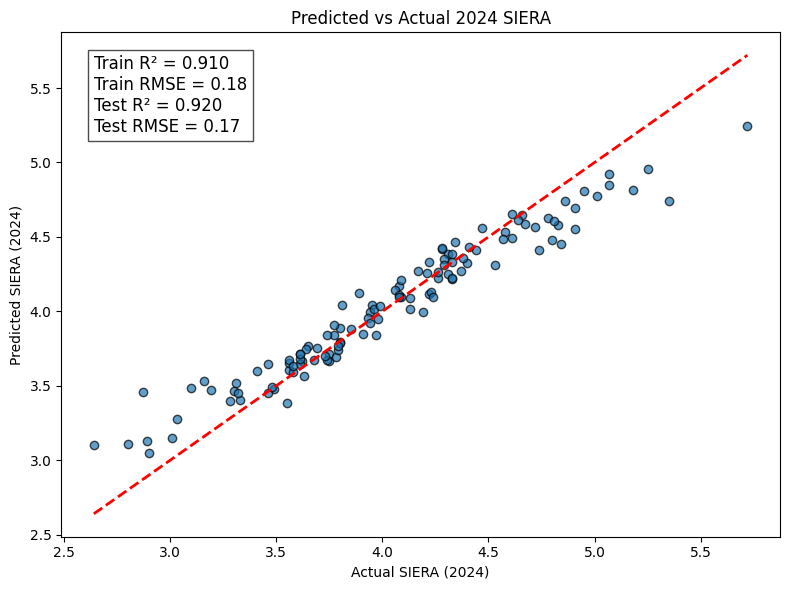


Predicted vs Actual Table (Sorted by Predicted SIERA):
                   Name  Actual_2024_SIERA  Predicted_2024_SIERA  SIERA_Diff
0         Tyler Glasnow               2.90              3.050750    0.150750
1        Emmanuel Clase               2.64              3.098750    0.458750
2            Chris Sale               2.80              3.109800    0.309800
3          Tarik Skubal               2.89              3.125750    0.235750
4           Bryan Abreu               3.01              3.146900    0.136900
5            Sonny Gray               3.03              3.275250    0.245250
6          Tanner Scott               3.55              3.384600   -0.165400
7              Joe Ryan               3.28              3.395200    0.115200
8          Tyler Rogers               3.33              3.406000    0.076000
9          Zack Wheeler               3.32              3.450250    0.130250
10          Pablo López               3.46              3.453850   -0.006150
11          Luke Wea

In [52]:
# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_all, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)

textstr = (
    f"Train R² = {r2_train:.3f}\n"
    f"Train RMSE = {rmse_train:.2f}\n"
    f"Test R² = {r2_test:.3f}\n"
    f"Test RMSE = {rmse_test:.2f}"
)

plt.text(
    x=y.min(), y=y.max(), s=textstr,
    fontsize=12, verticalalignment="top", bbox=dict(facecolor='white', alpha=0.7)
)

plt.title("Predicted vs Actual 2024 SIERA")
plt.xlabel("Actual SIERA (2024)")
plt.ylabel("Predicted SIERA (2024)")
plt.tight_layout()
plt.show()

# Creating the DataFrame
results_df = pd.DataFrame({
    "Name": full_train_df["Name"].reset_index(drop=True),
    "Actual_2024_SIERA": full_train_df["SIERA_2024"].reset_index(drop=True),
    "Predicted_2024_SIERA": pd.Series(y_pred_all).reset_index(drop=True)
})

results_df["SIERA_Diff"] = results_df["Predicted_2024_SIERA"] - results_df["Actual_2024_SIERA"]

# Sort by Predicted SIERA (ascending: lower SIERA = better pitcher)
sorted_results_df = results_df.sort_values(by="Predicted_2024_SIERA", ascending=True).reset_index(drop=True)

pd.set_option('display.max_rows', None)

print("\nPredicted vs Actual Table (Sorted by Predicted SIERA):")
print(sorted_results_df)





From our results, we can visually see the importance xFIP and CSW% have in our model, followed by Stuff+ and xERA . We also notice that our train and test R² score are about the same with an RMSE at 0.18, which is strong. With our test R² above 0.7, this highlights that the model performs quite well at capturing player-level outcomes with a fair amount of accuracy. Out of the full qualified player set (118 players), 9 players fell within ±0.01 SIERA of their actual 2024 value, 40 players fell within ±0.05 SIERA of their actual 2024 value, and 86 players fell within ±0.20 SIERA of their actual 2024 value, which means the model was able to closely mirror real-world performance for a significant portion of the test group. These players include both elite pitchers and more average contributors, suggesting that the model’s predictive power is not skewed toward only one end of the performance spectrum. 




Top Predictors of 2024 SIERA (Feature Importances):
            Feature  Importance
0              xFIP    0.130252
2              CSW%    0.121402
5            Stuff+    0.110588
1              xERA    0.107173
7        Z-Contact%    0.102703
4         Pitching+    0.095555
6              K/BB    0.052591
11       xFIP_delta    0.048758
3           Barrel%    0.048668
8        K/BB_delta    0.046856
12       xERA_delta    0.039994
9   Pitching+_delta    0.035385
13     Barrel_delta    0.033527
10        CSW_delta    0.026548


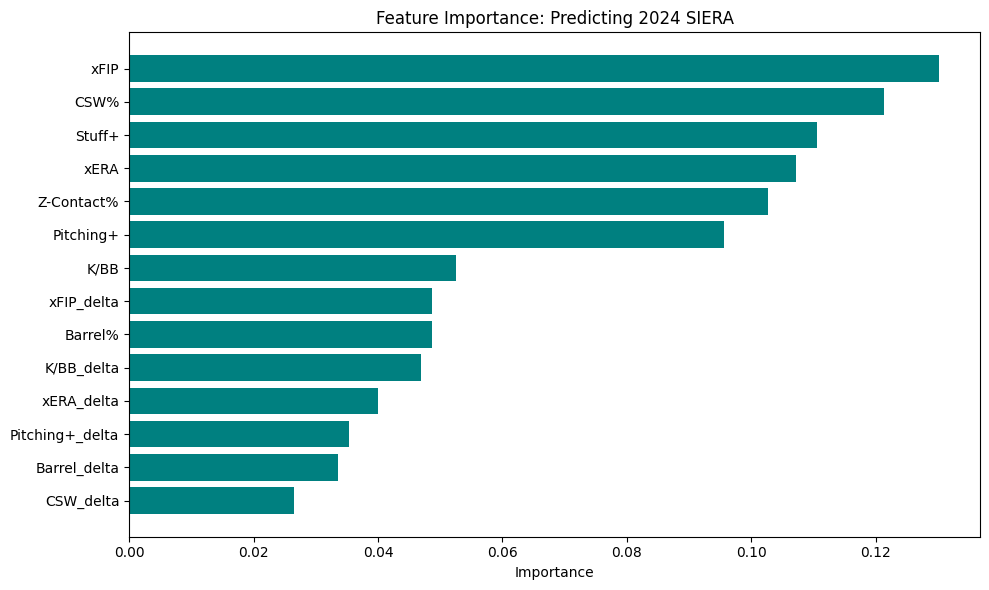

In [53]:

# Feature Importance Plot

all_features = X.columns.tolist()  

importances_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": rf_optimized.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop Predictors of 2024 SIERA (Feature Importances):")
print(importances_df)

plt.figure(figsize=(10, 6))
plt.barh(importances_df["Feature"], importances_df["Importance"], color='teal')
plt.gca().invert_yaxis()
plt.title("Feature Importance: Predicting 2024 SIERA")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()




In [54]:
importances_df.to_csv("feature_importance.csv", index=False)


More Organized Table and Plots

In [55]:
import plotly.graph_objects as go

# Compute Differences
results_df["Diff"] = results_df["Predicted_2024_SIERA"] - results_df["Actual_2024_SIERA"]
results_df["Diff"] = results_df["Diff"].round(3)
results_df["Abs_Diff"] = results_df["Diff"].abs()

# Sort by Absolute Difference (smallest first)

full_sorted_df = results_df.sort_values(by="Abs_Diff", ascending=True).copy()

# Rename columns for display

pretty_df = full_sorted_df.rename(columns={
    "Name": "Player",
    "Predicted_2024_SIERA": "Predicted SIERA",
    "Actual_2024_SIERA": "Actual SIERA",
    "Diff": "Diff"
})[["Player", "Predicted SIERA", "Actual SIERA", "Diff"]]

# Plotly Table

fig = go.Figure(data=[go.Table(
    header=dict(
        values=["<b>Player</b>", "<b>Predicted SIERA</b>", "<b>Actual SIERA</b>", "<b>Diff</b>"],
        fill_color='#2a3f5f',
        font=dict(color='white', size=14),
        align='center',
        height=30
    ),
    cells=dict(
        values=[
            pretty_df["Player"],
            pretty_df["Predicted SIERA"].round(3),
            pretty_df["Actual SIERA"].round(3),
            pretty_df["Diff"]
        ],
        fill_color='lavender',
        font=dict(size=13),
        align='center',
        height=28
    )
)])


fig.update_layout(
    title_text="All 2024 SIERA Predictions Sorted by Difference (Predicted - Actual)",
    title_x=0.5,
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()

# Save as HTML
fig.write_html("full_siera_table.html")


In [56]:
pretty_df.to_csv("siera_predictions_table.csv", index=False)


In [57]:
pip install html5lib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
import plotly.express as px

# scatter plot
fig = px.scatter(
    results_df,
    x='Actual_2024_SIERA',
    y='Predicted_2024_SIERA',
    color='SIERA_Diff',  
    color_continuous_scale='RdBu',
    hover_name='Name',   
    labels={
        'Actual_2024_SIERA': 'Actual 2024 SIERA',
        'Predicted_2024_SIERA': 'Predicted 2024 SIERA',
        'SIERA_Diff': 'Difference'
    },
    title='Predicted vs Actual SIERA'
)

# perfect prediction line (y = x)
fig.add_shape(
    type='line',
    x0=results_df['Actual_2024_SIERA'].min(),
    y0=results_df['Actual_2024_SIERA'].min(),
    x1=results_df['Actual_2024_SIERA'].max(),
    y1=results_df['Actual_2024_SIERA'].max(),
    line=dict(color='Black', dash='dash'),
    name='Perfect Prediction'
)

textstr = (
    f"Train R² = {r2_train:.3f}<br>"
    f"Train RMSE = {rmse_train:.2f}<br>"
    f"Test R² = {r2_test:.3f}<br>"
    f"Test RMSE = {rmse_test:.2f}"
)

fig.add_annotation(
    x=results_df['Actual_2024_SIERA'].min(),  
    y=results_df['Predicted_2024_SIERA'].max(),  
    text=textstr,
    showarrow=False,
    align='left',
    xanchor='left',
    yanchor='top',
    font=dict(size=12, color='black'),
    bordercolor='black',
    borderwidth=1,
    bgcolor='white',
    opacity=0.8
)

fig.show()


In [59]:
results_df["SIERA_Diff"] = results_df["Predicted_2024_SIERA"] - results_df["Actual_2024_SIERA"]
results_df.to_csv("siera_plot_data.csv", index=False)


In [60]:
fig.write_html("siera_scatter_plot2.html")
